# Intro

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
### access to google sheets
from google.colab import auth
import gspread
from google.auth import default
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [3]:
!apt-get install -qq libproj-dev libgdal-dev
!pip install cartopy
!pip install --no-binary shapely shapely --force
!pip install geopandas
!apt install libspatialindex-dev
!pip install rtree
!pip install cmocean

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.8 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113644 sha256=733e7ebc8e50525861ffa4d5502706118514c2e52dd138b96c98bd4b571e9fd9
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf638225ed578
Successfully built cartopy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 KB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Get

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import cmocean
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import geopandas
import rtree
import datetime as dt
import csv
import geopy.distance
from matplotlib.collections import LineCollection
import matplotlib.cm

In [5]:
### Shapefiles for maps
proj = ccrs.Mercator()

f = geopandas.read_file('/content/drive/MyDrive/fjord_Saguenay/lpr_000b16a_e/lpr_000b16a_e.shp')
canada_p = f.to_crs(proj)
f = geopandas.read_file('/content/drive/MyDrive/fjord_Saguenay/lhy_000h16a_e/lhy_000h16a_e.shp')
canada_h = f.to_crs(proj)
f = geopandas.read_file('/content/drive/MyDrive/fjord_Saguenay/lhy_000d16a_e/lhy_000d16a_e.shp')
canada_d = f.to_crs(proj)
f = geopandas.read_file('/content/drive/MyDrive/fjord_Saguenay/lhy_000c16a_e/lhy_000c16a_e.shp')
canada_c = f.to_crs(proj)
del(f)

In [6]:
### Scale bar
import os
from math import floor
import matplotlib

def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.9, 0.04), linewidth=4,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    y0, y1 = sbcy, sbcy ##################
    # Plot the scalebar
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth)
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy+200, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        zorder=2)

# Bathymetry

In [7]:
### NONNA 100
df_1 = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/NONNA100_4800N07000W.txt', sep='\t')
df_2 = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/NONNA100_4800N07100W.txt', sep='\t')
df_3 = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/NONNA100_4800N07200W.txt', sep='\t')
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
del(df_1, df_2, df_3)

df['Lat (DMS)'] = df['Lat (DMS)'].apply(lambda x: float(x[:2]) + float(x[3:5])/60 + float(x[6:12])/3600)
df['Long (DMS)'] = df['Long (DMS)'].apply(lambda x: -(float(x[:3]) + float(x[4:6])/60 + float(x[7:13])/3600))
df['Depth (m)'] = df['Depth (m)'].apply(lambda x: -x)

Lon = np.arange(-72, -68, .001)
Lat = np.arange(48, 49, .001)
for i, ilon in enumerate(Lon):
  Lon[i] = round(ilon, 3)
for i, ilat in enumerate(Lat):
  Lat[i] = round(ilat, 3)

dep_grid = np.empty((len(Lon), len(Lat)))
dep_grid[:] = np.nan

for irow, row in df.iterrows():
  lo, la, dep = row['Long (DMS)'], row['Lat (DMS)'], row['Depth (m)']
  i, j = np.where(Lon==round(lo, 3))[0][0], np.where(Lat==round(la, 3))[0][0]
  dep_grid[i, j] = dep
# del(df)

In [8]:
# ### NONNA 10 m resolution 
# csv_files = glob.glob('/content/drive/MyDrive/fjord_Saguenay/NONNA/*.txt')
# df_list = (pd.read_csv(f, sep='\t') for f in csv_files)
# df = pd.concat(df_list, ignore_index=True)
# del(df_list, csv_files)

# df['Lat (DMS)'] = df['Lat (DMS)'].apply(lambda x: float(x[:2]) + float(x[3:5])/60 + float(x[6:12])/3600)
# df['Long (DMS)'] = df['Long (DMS)'].apply(lambda x: -(float(x[:3]) + float(x[4:6])/60 + float(x[7:13])/3600))
# df['Depth (m)'] = df['Depth (m)'].apply(lambda x: -x)
# Lon = np.arange(-72, -68, .0001)
# Lat = np.arange(48, 49, .0001)
# for i, ilon in enumerate(Lon):
#   Lon[i] = round(ilon, 4)
# for i, ilat in enumerate(Lat):
#   Lat[i] = round(ilat, 4)

# dep_grid = np.empty((len(Lon), len(Lat)))
# dep_grid[:] = np.nan
# for irow, row in df.iterrows():
#   lo, la, dep = row['Long (DMS)'], row['Lat (DMS)'], row['Depth (m)']
#   i, j = np.where(Lon==round(lo, 4))[0][0], np.where(Lat==round(la, 4))[0][0]
#   dep_grid[i, j] = dep

# del(df)

In [9]:
# ax = plt.axes(projection = ccrs.Mercator())
# # ax.set_extent([-71, -70.55, 48.31, 48.45])
# ax.gridlines(draw_labels=True)
# cf = ax.pcolormesh(Lon, Lat, dep_grid.T, transform=ccrs.PlateCarree())

#### 24 stations
# ax.plot(-70.96551111, 48.4455694, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.92509444, 48.4351444, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.88678333, 48.4280611, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.83505953, 48.41662455, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.83946383, 48.41338998, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.84297754, 48.4101482, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.75592249, 48.41154575, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.74600586, 48.38893676, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.73505844, 48.38858995, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.72341914, 48.38739753, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.77277637, 48.36288178, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.80879998, 48.35332171, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.82113777, 48.34597312, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.82845236, 48.33415047, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.84598319, 48.34088204, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.86557598, 48.35080985, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.73750427, 48.35700723, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.72554028, 48.36423599, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.71051611, 48.3734102, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.61598996, 48.37442746, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.61956649, 48.36611331, 'k.', transform=ccrs.Geodetic())
# ax.plot(-70.62322855, 48.35762533, 'k.', transform=ccrs.Geodetic())

# Depth map

In [ ]:
print(np.nanmin(dep_grid), np.nanmax(dep_grid))

-333.88 6.25


/usr/local/lib/python3.9/dist-packages/cartopy/mpl/geoaxes.py:801: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS84 el ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


Text(0.35, 0.23, 'Baie des Ha! Ha!')

/usr/local/lib/python3.9/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


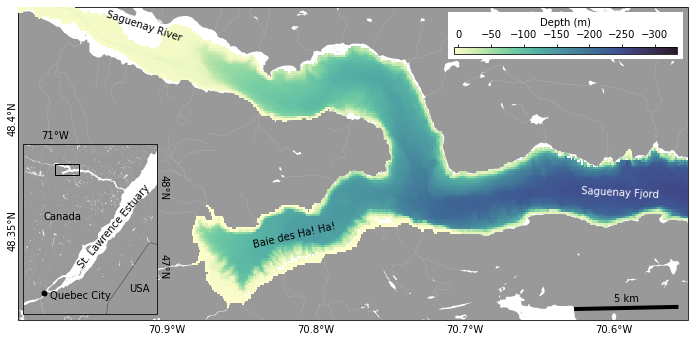

In [ ]:
proj = ccrs.Mercator()

fig, ax = plt.subplots(1, 1, figsize=(12,12), subplot_kw=dict(projection=proj))
ax.set_extent([-71, -70.55, 48.31, 48.45])
# ax.tick_params(axis="y", direction='in', length=8)
# ax.set_extent([-71, -69, 48, 48.5])
# ax.set_extent([-71.3, -69.5, 48, 48.6])  # fjord
gl = ax.gridlines(draw_labels = True, alpha=0)
gl.top_labels = False
gl.right_labels = False
gl.ylabel_style = dict(rotation=90, va='center', ha='center')
gl.ylocator = mticker.FixedLocator([48.35, 48.4])
gl.ylines = False

ax.add_geometries(canada_p['geometry'], crs=proj, facecolor='0.6')
ax.add_geometries(canada_h['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_c['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_d['geometry'], crs=proj, edgecolor='w', facecolor='None', linewidth=0.1)

pcm = ax.contourf(Lon, Lat, dep_grid.T, np.arange(-260, 20, 20),
                  transform=ccrs.PlateCarree(), zorder=30, 
                  cmap=cmocean.cm.deep_r)

cbbox = inset_axes(ax, '35%', '15%', loc=1)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(axis='both', left=False, top=False, 
   right=False, bottom=False, labelleft=False,
    labeltop=False, labelright=False, labelbottom=False)
cbbox.set_facecolor([1,1,1,1])
cbax = inset_axes(cbbox, '95%', '15%', loc = 8)

cb = plt.colorbar(pcm, cax=cbax, orientation='horizontal')
cb.set_label('Depth (m)')
cb.ax.invert_xaxis()
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

scale_bar(ax, ccrs.Mercator(), 5)

### Small map - larger area
smap = inset_axes(ax, '20%', '55%', loc=3, axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                  axes_kwargs=dict(projection=ccrs.Mercator()))
smap.set_extent([-71.6, -69.1, 46.55, 48.7])
gl = smap.gridlines(draw_labels = True, alpha=0)
gl.bottom_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-71])
gl.ylocator = mticker.FixedLocator([47, 48])
gl.ylabel_style = dict(rotation=270, va='bottom', ha='center')
gl.xlabel_style = dict(va='baseline')

# smap.add_feature(cfeature.LAND.with_scale('10m'), facecolor='0.6', edgecolor='k', linewidth=.3)
# smap.add_feature(cfeature.LAKES, facecolor='w', edgecolor='k', linewidth=.1)
smap.add_geometries(canada_p['geometry'], crs=proj, facecolor='0.6')
smap.add_geometries(canada_h['geometry'], crs=proj, facecolor='w')
smap.add_geometries(canada_c['geometry'], crs=proj, facecolor='w')
smap.add_feature(cfeature.BORDERS, linewidth=.3)
smap.plot(-71.208056, 46.813889, 'o', ms=5, mfc='k', mec='k', transform=ccrs.Geodetic())
smap.text(-71.1, 46.75, 'Quebec City', transform=ccrs.Geodetic())
smap.text(.4, .27, 'St. Lawrence Estuary', rotation=50, transform=smap.transAxes)
smap.text(.15, .55, 'Canada', transform=smap.transAxes)
smap.text(.79, .13, 'USA', transform=smap.transAxes)

rect = mpatches.Rectangle((-71, 48.31), .45, .14, linewidth=1, edgecolor='k', facecolor='none', 
                           transform=ccrs.Geodetic(), zorder=40)
smap.add_patch(rect)
smap.set_facecolor('0.6')

ax.text(.13, .89, 'Saguenay River', rotation=-18, transform=ax.transAxes, zorder=40)
ax.text(.84, .39, 'Saguenay Fjord', rotation=-3, c='w', transform=ax.transAxes, zorder=40)
ax.text(.35, .23, 'Baie des Ha! Ha!', rotation=13, transform=ax.transAxes, zorder=40)

# plt.savefig('/content/drive/MyDrive/fjord_Saguenay/fjord_carte.png', dpi=600, facecolor='w')

# PyKML - pas besoin

In [ ]:
### Données
# !pip install pykml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 KB 2.1 MB/s eta 0:00:00


In [ ]:
from pykml import parser

In [ ]:
kml_file = '/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/_BoueesDerivantes/BaliseSpot/spot_messages(1).kml'

with open(kml_file) as f:
  doc = parser.parse(f)

In [ ]:
doc

In [ ]:
from lxml import etree

In [ ]:
etree.tostring(doc, pretty_print=True)

b'<kml xmlns="http://earth.google.com/kml/2.0" creator="SPOT Inc http://www.findmespot.com/">\n  <Document>\n    <Folder>\n      <name>Waypoints</name>\n      <Placemark>\n        <name>1-</name>\n        <Point>\n          <altitudeMode>clampedToGround</altitudeMode>\n          <coordinates>-71.05316,48.43254,0.000000</coordinates>\n        </Point>\n        <Snippet><![CDATA[0-3169130 @ 06/11/2019 09:10:04 AM]]></Snippet>\n        <description><![CDATA[<h2>0-3169130 @ 06/11/2019 09:10:04 AM</h2> <p> ""</p>]]></description>\n        <styleUrl>#gv_waypoint</styleUrl>\n      </Placemark>\n      <Placemark>\n        <name>2-</name>\n        <Point>\n          <altitudeMode>clampedToGround</altitudeMode>\n          <coordinates>-71.05157,48.43262,0.000000</coordinates>\n        </Point>\n        <Snippet><![CDATA[0-3169130 @ 06/11/2019 09:20:08 AM]]></Snippet>\n        <description><![CDATA[<h2>0-3169130 @ 06/11/2019 09:20:08 AM</h2> <p> ""</p>]]></description>\n        <styleUrl>#gv_wayp

# Buoys

In [ ]:
headers = ['Time', 'Buoy', 'SpotMessage', 'Lat', 'Lon', 'a', 'b', 'c']
bouees = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/_BoueesDerivantes/BaliseSpot/TOUTES_LES_BALISES.csv',
                     sep=',', names=headers, quoting=csv.QUOTE_NONE)
bouees = bouees.drop(['a', 'b', 'c'], axis='columns')
bouees['Time'].replace({'"': ''}, regex=True, inplace=True)
bouees.replace({'No GPS': np.nan}, regex=True, inplace=True)
bouees = bouees.astype({'Lat': float, 'Lon': float})
bouees['Time'] = bouees['Time'].astype('datetime64[ns]')
bouees.dtypes

Time           datetime64[ns]
Buoy                   object
SpotMessage            object
Lat                   float64
Lon                   float64
dtype: object

In [ ]:
for c in bouees:
  print(bouees[c].value_counts())

2019-06-11 11:15:06    3
2019-06-11 15:50:07    2
2019-06-11 12:13:51    2
2019-06-11 16:00:07    2
2019-06-11 14:13:36    2
                      ..
2019-06-20 20:57:52    1
2019-06-21 07:34:35    1
2019-06-21 07:34:38    1
2019-06-21 07:43:50    1
2019-06-11 09:10:04    1
Name: Time, Length: 1679, dtype: int64
0-3170346    223
0-3169830    220
0-3171125    130
0-3171220    129
0-3169136    122
0-3171122    121
0-3171208    107
0-3171130     95
0-3169324     88
0-3171138     88
0-3169816     87
0-3171123     75
0-3171295     51
0-3169130     34
0-3169251     30
0-3170354     27
0-3169128     24
0-3170353     23
0-3171131     17
0-3171299      7
Name: Buoy, dtype: int64
UNLIMITED-TRACK    1533
STOP                136
POWER-OFF            29
Name: SpotMessage, dtype: int64
48.39389    12
48.39395    10
48.39499     9
48.33581     9
48.39396     8
            ..
48.41158     1
48.36044     1
48.36014     1
48.41116     1
48.43254     1
Name: Lat, Length: 1351, dtype: int64
-70.71548    2

In [ ]:
### Inspection of data
nbalise = '3170346'
b_s01 = bouees[bouees['Buoy']=='0-'+nbalise]
b_s01 = b_s01.iloc[::-1]
b_s01 = b_s01[(b_s01['Time']>np.datetime64('2019-06-27')) & (b_s01['Time']<np.datetime64('2019-06-30'))]
# b_s01 = b_s01[b_s01['SpotMessage'] != 'POWER-OFF']
b_s01

,Time,Buoy,SpotMessage,Lat,Lon
478,2019-06-27 09:37:56,0-3170346,POWER-OFF,NaN,NaN
471,2019-06-27 10:03:36,0-3170346,UNLIMITED-TRACK,48.35082,-70.80896
466,2019-06-27 10:12:51,0-3170346,UNLIMITED-TRACK,48.35041,-70.81055
460,2019-06-27 10:22:57,0-3170346,UNLIMITED-TRACK,48.34982,-70.81223
452,2019-06-27 10:32:56,0-3170346,UNLIMITED-TRACK,48.34922,-70.81390
443,2019-06-27 10:42:55,0-3170346,UNLIMITED-TRACK,48.34874,-70.81577
434,2019-06-27 10:52:51,0-3170346,UNLIMITED-TRACK,48.34833,-70.81769
425,2019-06-27 11:03:21,0-3170346,UNLIMITED-TRACK,48.34794,-70.81992
416,2019-06-27 11:12:47,0-3170346,STOP,48.34755,-70.82201
406,2019-06-27 11:22:42,0-3170346,UNLIMITED-TRACK,48.34710,-70.82428


In [ ]:
### Selection of trajectories
nbalise = '3171295'   # st 5 -> cap a lest
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-11')) & (bs['Time']<np.datetime64('2019-06-13'))]
bs = bs.iloc[:11:-1]
bs01 = bs

nbalise = '3171123'   # st 10 -> retention debut La Baie
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs.iloc[::-1]
bs = bs.iloc[10:]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs02 = bs

nbalise = '3169816'   # st 17 -> retention fond La Baie
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[:16:-1]
bs03 = bs

nbalise = '3169324'   # st 16 - retention fond La Baie
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-20')) & (bs['Time']<np.datetime64('2019-06-21'))]
bs = bs.iloc[::-1]
bs = bs.iloc[5:]
bs04 = bs

nbalise = '3169324'   # st 10 - lap and retention?
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs.iloc[::-1]
bs = bs.iloc[:-19]
bs05 = bs

nbalise = '3171208'   # cap ouest -> anse sable (MONTANT)
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[::-1]
bs = bs.iloc[10:]
bs06 = bs

nbalise = '3171122'   # st 9 -> anse la croix
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-20')) & (bs['Time']<np.datetime64('2019-06-21'))]
bs = bs.iloc[::-1]
bs07 = bs

nbalise = '3171122'   # St Rose du Nord vers aval & little lap
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-21')) & (bs['Time']<np.datetime64('2019-06-22'))]
bs = bs.iloc[::-1]
bs08 = bs

nbalise = '3171122'   # st 13 ou 14 -> retention et retour
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[::-1]
bs09 = bs

nbalise = '3169136'   # st 10 -> retention La Baie (TRES BEAU ou BATEAU)
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[::-1]
bs = bs.iloc[9:-1]
bs10 = bs

nbalise = '3171220'   # st 17 -> retention fond La Baie
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs.iloc[::-1]
bs = bs.iloc[:-21]
bs11 = bs

nbalise = '3171125'   # retour du fjord vers amont et La Baie BEAU !
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-13')) & (bs['Time']<np.datetime64('2019-06-14'))]
bs = bs.iloc[::-1]
bs12 = bs

nbalise = '3169830'   # st 1 -> anse sable -> anse croix LONG BEAU
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-11')) & (bs['Time']<np.datetime64('2019-06-14'))]
bs = bs.iloc[::-1]
bs = bs.iloc[:-21]
bs13 = bs

nbalise = '3169830'   # st 15 -> retention fond La Baie
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[::-1]
bs = bs.iloc[:-8]
bs14 = bs

nbalise = '3170346'   # st 1 -> anse sable -> anse croix 
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-11')) & (bs['Time']<np.datetime64('2019-06-13'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[::-1]
bs = bs.iloc[:-14]
bs15 = bs

nbalise = '3170346'   # st 9 -> prox anse croix 
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-20')) & (bs['Time']<np.datetime64('2019-06-21'))]
bs = bs.iloc[::-1]
bs16 = bs

nbalise = '3170346'   # St Rose du Nord vers aval
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-21')) & (bs['Time']<np.datetime64('2019-06-22'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[::-1]
bs17 = bs

nbalise = '3170346'   # st 14 -> retention fond La Baie
bs = bouees[bouees['Buoy']=='0-'+nbalise]
bs = bs[(bs['Time']>np.datetime64('2019-06-27')) & (bs['Time']<np.datetime64('2019-06-28'))]
bs = bs[bs['SpotMessage'] != 'POWER-OFF']
bs = bs.iloc[::-1]
bs = bs.iloc[:-10]
bs18 = bs

bss = [bs01, bs02, bs03, bs04, bs05, bs06, bs07, bs08, bs09, bs10, bs11, bs12,
       bs13, bs14, bs15, bs16, bs17, bs18]

In [ ]:
### Points and segments for inspection
points = np.array([bs['Lon'], bs['Lat']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
### Speeds in cm/s
points_lalo = np.array([bs['Lat'], bs['Lon']]).T.reshape(-1, 1, 2)
times = - (bs['Time'].values[:-1] - bs['Time'].values[1:])   # in nanoseconds
speeds = np.zeros((len(times)))
for i, p in enumerate(points[:-1]):
  distance = geopy.distance.geodesic(points_lalo[i], points_lalo[i+1]).m
  speeds[i] = (distance*100) / (float(times[i]) *1e-9)
  print(distance)
# print(nbalise)
# print(speeds)

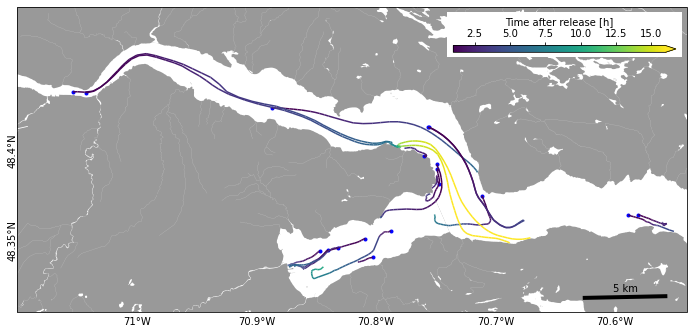

In [ ]:
### Plot of selected buoy trajectories
proj = ccrs.Mercator()

fig, ax = plt.subplots(1, 1, figsize=(12,12), subplot_kw=dict(projection=proj))
ax.set_extent([-71.1, -70.54, 48.31, 48.48])
# ax.tick_params(axis="y", direction='in', length=8)
# ax.set_extent([-71, -69, 48, 48.5])
# ax.set_extent([-71.3, -69.5, 48, 48.6])  # fjord
gl = ax.gridlines(draw_labels = True, alpha=0)
gl.top_labels = False
gl.right_labels = False
gl.ylabel_style = dict(rotation=90, va='center', ha='center')
gl.ylocator = mticker.FixedLocator([48.35, 48.4])
gl.ylines = False

ax.add_geometries(canada_p['geometry'], crs=proj, facecolor='0.6')   # shapefiles
ax.add_geometries(canada_h['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_c['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_d['geometry'], crs=proj, edgecolor='w', facecolor='None', linewidth=0.1)

# ax.plot(b_s01['Lon'], b_s01['Lat'], marker='o', linestyle='', zorder=40)  # positions
norm = plt.Normalize(1, 16)   # buoy trajectory with speed

for bs in bss:
  ax.plot(bs['Lon'].values[0], bs['Lat'].values[0], 'bo', ms=3, transform=ccrs.Geodetic(), zorder=39)
  points = np.array([bs['Lon'], bs['Lat']]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  time0 = bs['Time'].values[0]
  times = np.zeros((len(points[1:])))
  for i, it in enumerate(times):
    times[i] = (float(bs['Time'].values[i+1] - time0) * 1e-9 ) / 3600
  lc = LineCollection(segments, cmap='viridis', norm=norm, transform=ccrs.Geodetic(), zorder=40)
  lc.set_array(times)
  ax.add_collection(lc)

# Scale bar
scale_bar(ax, ccrs.Mercator(), 5)

### Legend
cbbox = inset_axes(ax, '35%', '15%', loc=1)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(axis='both', left=False, top=False, 
   right=False, bottom=False, labelleft=False,
    labeltop=False, labelright=False, labelbottom=False)
cbbox.set_facecolor([1,1,1,1])
cbax = inset_axes(cbbox, '95%', '15%', loc = 8)

cb = plt.colorbar(lc, cax=cbax, orientation='horizontal', extend='max')
cb.set_label('Time after release [h]')  ## ⁻¹ ##
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/content/drive/MyDrive/fjord_Saguenay/all_buoys.png', dpi=600, facecolor='w')

/usr/local/lib/python3.9/dist-packages/cartopy/mpl/geoaxes.py:801: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS84 el ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


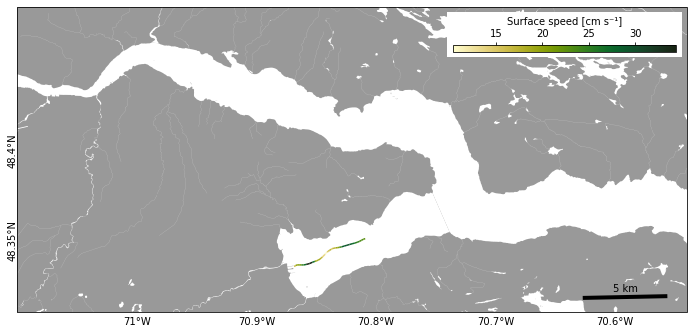

In [ ]:
### Investigation of buoy trajectories
proj = ccrs.Mercator()

fig, ax = plt.subplots(1, 1, figsize=(12,12), subplot_kw=dict(projection=proj))
ax.set_extent([-71.1, -70.54, 48.31, 48.48])
# ax.tick_params(axis="y", direction='in', length=8)
# ax.set_extent([-71, -69, 48, 48.5])
# ax.set_extent([-71.3, -69.5, 48, 48.6])  # fjord
gl = ax.gridlines(draw_labels = True, alpha=0)
gl.top_labels = False
gl.right_labels = False
gl.ylabel_style = dict(rotation=90, va='center', ha='center')
gl.ylocator = mticker.FixedLocator([48.35, 48.4])
gl.ylines = False

ax.add_geometries(canada_p['geometry'], crs=proj, facecolor='0.6')   # shapefiles
ax.add_geometries(canada_h['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_c['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_d['geometry'], crs=proj, edgecolor='w', facecolor='None', linewidth=0.1)

# ax.plot(b_s01['Lon'], b_s01['Lat'], marker='o', linestyle='', zorder=40)  # positions

norm = plt.Normalize(speeds.min(), speeds.max())   # buoy trajectory with speed
lc = LineCollection(segments, cmap=cmocean.cm.speed, norm=norm, transform=ccrs.Geodetic(), zorder=40)
lc.set_array(speeds)
ax.add_collection(lc)

scale_bar(ax, ccrs.Mercator(), 5)  # Scale bar

### Legend
cbbox = inset_axes(ax, '35%', '15%', loc=1)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(axis='both', left=False, top=False, 
   right=False, bottom=False, labelleft=False,
    labeltop=False, labelright=False, labelbottom=False)
cbbox.set_facecolor([1,1,1,1])
cbax = inset_axes(cbbox, '95%', '15%', loc = 8)

cb = plt.colorbar(lc, cax=cbax, orientation='horizontal')
cb.set_label('Surface speed [cm s⁻¹]')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('/content/drive/MyDrive/fjord_Saguenay/bouee_'+nbalise+'_investig.png', dpi=600, facecolor='w')

# Ichthyo

In [ ]:
sh = gc.open('Derive_OSMO_Saguenay_2019').sheet1
df = pd.DataFrame(sh.get_all_records())
df['Date'] = df['Date'].astype('datetime64[ns]')
df.dtypes

Mission               int64
Station               int64
Date         datetime64[ns]
Lon                 float64
Lat                 float64
OSMO_stA            float64
OSMO_stB            float64
OSMO_stC            float64
OSMO_stD            float64
OSMO_stNS           float64
dtype: object

In [ ]:
df

,Mission,Station,Date,Lon,Lat,OSMO_stA,OSMO_stB,OSMO_stC,OSMO_stD,OSMO_stNS
0,2,1,2019-06-10,-71.053639,48.432798,0.00000,0.000000,0.000000,0.000000,0.000000
1,2,2,2019-06-10,-71.002942,48.450608,0.00000,0.000000,0.000000,0.000000,0.000000
2,2,3,2019-06-10,-70.965511,48.445569,0.00000,0.000000,0.000000,0.000000,0.000000
3,2,4,2019-06-12,-70.925094,48.435144,0.00000,0.000000,0.000000,0.000000,0.000000
4,2,5,2019-06-12,-70.886783,48.428061,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
67,4,20,2019-06-27,-70.725540,48.364236,7.40715,7.407150,303.693142,414.800389,44.442899
68,4,21,2019-06-27,-70.710516,48.373410,0.00000,15.864005,158.640049,761.472237,47.592015
69,4,22,2019-06-27,-70.615990,48.374427,0.00000,0.000000,14.451680,209.549364,14.451680
70,4,23,2019-06-27,-70.619566,48.366113,0.00000,0.000000,196.018088,2397.452004,90.469887


In [ ]:
df_m2 = df[df['Mission']==2]
df_m3 = df[df['Mission']==3]
df_m4 = df[df['Mission']==4]

<ipython-input-15-363ac43c57cf>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  CMAP = matplotlib.cm.get_cmap('viridis')


1 0.0
2 68.569809603
3 151.51977119999998
4 3254.9228295999997
5 1341.5782421000001
6 127.89038117
7 445.5679499
8 285.762770567
9 324.58116339000003
10 821.67215593
11 652.25735113
12 385.87855628
13 475.53286274
14 242.43664188
15 146.669763474
16 51.761035666
17 29.839690596
18 128.043426314
19 969.37243184
20 587.19575026
21 423.39270555
22 565.07712955
23 581.51194836
24 256.674794826


/usr/local/lib/python3.9/dist-packages/cartopy/mpl/geoaxes.py:801: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS84 el ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


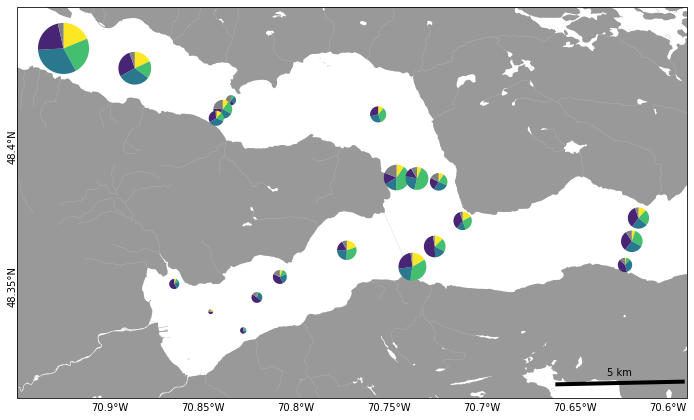

In [ ]:
CMAP = matplotlib.cm.get_cmap('viridis')

def plot_pie(sta, stb, stc, std, stns, lon, lat):  
  sttotal = sta + stb + stc + std + stns
  print(row[1], sttotal)
  if sttotal == 0:
    ax.scatter(lon, lat, s=2, marker='o', linewidths=.2, fc='none', ec='k', transform=ccrs.Geodetic(), zorder=40)
  else:
    ini = np.pi / 2
    r1 = sta / sttotal
    r2 = r1 + (stb / sttotal)
    r3 = r2 + (stc / sttotal)
    r4 = r3 + (std / sttotal)

    x = [0] + np.cos(np.linspace(ini, ini- 2 * np.pi * r1, 50)).tolist()
    y = [0] + np.sin(np.linspace(ini, ini- 2 * np.pi * r1, 50)).tolist()
    xy1 = list(zip(x,y))

    x = [0] + np.cos(np.linspace(ini - 2 * np.pi * r1, ini - 2 * np.pi * r2, 50)).tolist()
    y = [0] + np.sin(np.linspace(ini - 2 * np.pi * r1, ini - 2 * np.pi * r2, 50)).tolist()
    xy2 = list(zip(x,y))

    x = [0] + np.cos(np.linspace(ini - 2 * np.pi * r2, ini - 2 * np.pi * r3, 50)).tolist()
    y = [0] + np.sin(np.linspace(ini - 2 * np.pi * r2, ini - 2 * np.pi * r3, 50)).tolist()
    xy3 = list(zip(x,y))

    x = [0] + np.cos(np.linspace(ini - 2 * np.pi * r3, ini - 2 * np.pi * r4, 50)).tolist()
    y = [0] + np.sin(np.linspace(ini - 2 * np.pi * r3, ini - 2 * np.pi * r4, 50)).tolist()
    xy4 = list(zip(x,y))

    x = [0] + np.cos(np.linspace(ini - 2 * np.pi * r4, ini - 2 * np.pi, 50)).tolist()
    y = [0] + np.sin(np.linspace(ini - 2 * np.pi * r4, ini - 2 * np.pi, 50)).tolist()
    xy5 = list(zip(x,y))

    size = sttotal * .8
    ax.scatter(lon, lat, marker=xy1, zorder=40,
                s=size, facecolor=CMAP(1.0), ec='none', transform=ccrs.Geodetic())
    ax.scatter(lon, lat, marker=xy2, zorder=40,
               s=size, facecolor=CMAP(0.7), ec='none', transform=ccrs.Geodetic())
    ax.scatter(lon, lat, marker=xy3, zorder=40,
               s=size, facecolor=CMAP(0.4), ec='none', transform=ccrs.Geodetic())
    ax.scatter(lon, lat, marker=xy4, zorder=40,
               s=size, facecolor=CMAP(0.1), ec='none', transform=ccrs.Geodetic())
    ax.scatter(lon, lat, marker=xy5, zorder=40,
                s=size, facecolor='grey', ec='none', transform=ccrs.Geodetic())

df_plot = df_m3

proj = ccrs.Mercator()

fig, ax = plt.subplots(1, 1, figsize=(12,12), subplot_kw=dict(projection=proj))
# ax.set_extent([-71.1, -70.54, 48.31, 48.48])  # Riviere & Upper fjord
# ax.set_extent([-71, -70.55, 48.31, 48.45])  # Upper fjord zoomed - bathymetry map
ax.set_extent([-70.95, -70.59, 48.31, 48.45])  # Upper fjord - zoomed to ichthyo from st. 4
# ax.tick_params(axis="y", direction='in', length=8)
# ax.set_extent([-71, -69, 48, 48.5])
# ax.set_extent([-71.3, -69.5, 48, 48.6])  # fjord
gl = ax.gridlines(draw_labels = True, alpha=0)
gl.top_labels = False
gl.right_labels = False
gl.ylabel_style = dict(rotation=90, va='center', ha='center')
gl.ylocator = mticker.FixedLocator([48.35, 48.4])
gl.ylines = False

ax.add_geometries(canada_p['geometry'], crs=proj, facecolor='0.6')   # shapefiles
ax.add_geometries(canada_h['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_c['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_d['geometry'], crs=proj, edgecolor='w', facecolor='None', linewidth=0.1)

for i, row in df_plot.iterrows():
  plot_pie(row[5], row[6], row[7], row[8], 
           row[9], row[3], row[4])
  
### Scale bar
scale_bar(ax, ccrs.Mercator(), 5)

### Legend
# cbbox = inset_axes(ax, '35%', '15%', loc=1)
# [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
# cbbox.tick_params(axis='both', left=False, top=False, 
#    right=False, bottom=False, labelleft=False,
#     labeltop=False, labelright=False, labelbottom=False)
# cbbox.set_facecolor([1,1,1,1])
# cbax = inset_axes(cbbox, '95%', '15%', loc = 8)

# cb = plt.colorbar(lc, cax=cbax, orientation='horizontal', extend='max')
# cb.set_label('Time after release [h]')  ## ⁻¹ ##
# cb.ax.xaxis.set_ticks_position('top')
# cb.ax.xaxis.set_label_position('top')

plt.savefig('/content/drive/MyDrive/fjord_Saguenay/OSMO_mission3.png', dpi=600, facecolor='w')

# Chl-a

In [ ]:
sh = gc.open('Chl-a_Saguenay_2019').sheet1
df = pd.DataFrame(sh.get_all_records())
# df['Date'] = df['Date'].astype('datetime64[ns]')
df = df.iloc[:, :6]
df.dtypes

Station             int64
Lon               float64
Lat               float64
Chl-a_11-13jun    float64
Chl-a_17-19jun    float64
Chl-a_25-27jun    float64
dtype: object

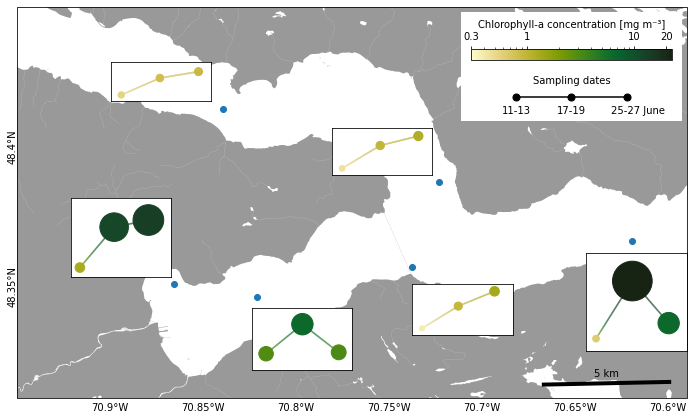

In [ ]:
proj = ccrs.Mercator()

fig, ax = plt.subplots(1, 1, figsize=(12,12), subplot_kw=dict(projection=proj))
# ax.set_extent([-71.1, -70.54, 48.31, 48.48])  # Riviere & Upper fjord
# ax.set_extent([-71, -70.55, 48.31, 48.45])  # Upper fjord zoomed - bathymetry map
ax.set_extent([-70.95, -70.59, 48.31, 48.45])  # Upper fjord - zoomed to ichthyo from st. 4
# ax.tick_params(axis="y", direction='in', length=8)
# ax.set_extent([-71, -69, 48, 48.5])
# ax.set_extent([-71.3, -69.5, 48, 48.6])  # fjord
gl = ax.gridlines(draw_labels = True, alpha=0)
gl.top_labels = False
gl.right_labels = False
gl.ylabel_style = dict(rotation=90, va='center', ha='center')
gl.ylocator = mticker.FixedLocator([48.35, 48.4])
gl.ylines = False

ax.add_geometries(canada_p['geometry'], crs=proj, facecolor='0.6')   # shapefiles
ax.add_geometries(canada_h['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_c['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_d['geometry'], crs=proj, edgecolor='w', facecolor='None', linewidth=0.1)

norm = mcolors.LogNorm(vmin=.3, vmax=22.5)

def plot_clo(ax_st, df_st):
  # [ax_st.spines[k].set_visible(False) for k in ax_st.spines]
  ax_st.tick_params(axis='both', left=False, top=False, 
                    right=False, bottom=False, labelleft=False,
                    labeltop=False, labelright=False, labelbottom=False)
  # ax_st.set_facecolor([1,1,1,1])

  ax.plot(df_st.iat[0,1], df_st.iat[0,2], 'o', c='tab:blue', zorder=40, transform=ccrs.Geodetic())

  # Lines between scatter points
  x, y, colss = np.linspace(.2, .5, 300), np.linspace(df_st.iloc[0,3], df_st.iloc[0,4], 300), np.linspace(df_st.iloc[0,3], df_st.iloc[0,4], 300)
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  lc = LineCollection(segments, cmap=cmocean.cm.speed, norm=norm, zorder=12)
  lc.set_array(colss)
  ax_st.add_collection(lc)
  x, y, colss = np.linspace(.5, .8, 300), np.linspace(df_st.iloc[0,4], df_st.iloc[0,5], 300), np.linspace(df_st.iloc[0,4], df_st.iloc[0,5], 300)
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  lc = LineCollection(segments, cmap=cmocean.cm.speed, norm=norm, zorder=12)
  lc.set_array(colss)
  ax_st.add_collection(lc)

  sca = ax_st.scatter([.2,.5,.8], df_st.iloc[0,3:], s=df_st.iloc[0,3:] *70, 
                      c = df_st.iloc[0,3:], cmap=cmocean.cm.speed, norm=norm, zorder=13)
  return sca

wid, hei = .15, .17

### St 7
df_st = df[df['Station']==7]
ax_st = ax.inset_axes([.14, .76, wid, .1])
plot_clo(ax_st, df_st)
ax_st.set_ylim(.48, 1.07)
ax_st.set_xlim(.12, .9)

### St 18   benjamin
df_st = df[df['Station']==18]
ax_st = ax.inset_axes([.08, .31, wid, .2])
plot_clo(ax_st, df_st)
ax_st.set_ylim(-1, 19)
ax_st.set_xlim(.12, 1)

### St 15
df_st = df[df['Station']==15]
ax_st = ax.inset_axes([.35, .07, wid, .16])
plot_clo(ax_st, df_st)
ax_st.set_ylim(1, 8.5)
ax_st.set_xlim(.08, .91)

### St 19
df_st = df[df['Station']==19]
ax_st = ax.inset_axes([.59, .16, wid, .13])
plot_clo(ax_st, df_st)
ax_st.set_ylim(.2, 1.5)
ax_st.set_xlim(.12, .95)

### St 23   St Rose
df_st = df[df['Station']==23]
ax_st = ax.inset_axes([.85, .12, wid, .25])
plot_clo(ax_st, df_st)
ax_st.set_ylim(-4, 33)
ax_st.set_xlim(.12, .95)

### St 12
df_st = df[df['Station']==12]
ax_st = ax.inset_axes([.47, .57, wid, .12])
sca = plot_clo(ax_st, df_st)
ax_st.set_ylim(.3, 1.4)
ax_st.set_xlim(.12, .91)

# ax.scatter(df_plot['Lon'], df_plot['Lat'], s=df_plot['Pheo_ugL']*100, zorder=40, transform=ccrs.Geodetic())

### Scale bar
scale_bar(ax, ccrs.Mercator(), 5, location=(0.87, 0.04))

### Legend
cbbox = inset_axes(ax, '33%', '28%', loc=1)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(axis='both', left=False, top=False, 
   right=False, bottom=False, labelleft=False,
    labeltop=False, labelright=False, labelbottom=False)
cbbox.set_facecolor([1,1,1,1])
cbax = inset_axes(cbbox, '91%', '10%', loc=9, bbox_to_anchor=(0, -.29, 1, 1),
                   bbox_transform=cbbox.transAxes)

cb = plt.colorbar(sca, cax=cbax, orientation='horizontal')
cb.set_label('Chlorophyll-a concentration [mg m⁻³]')  ## ⁻¹ µ ³ ##
cb.set_ticks([0.3, 1, 10, 20])
cb.set_ticklabels(['0.3', '1', '10', '20'])
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

sca_ax = inset_axes(cbbox, '55%', '20%', loc=8, bbox_to_anchor=(0, .08, 1, 1),
                    bbox_transform=cbbox.transAxes)
[sca_ax.spines[k].set_visible(False) for k in sca_ax.spines]
sca_ax.tick_params(axis='both', left=False, top=False, 
   right=False, bottom=False, labelleft=False,
    labeltop=False, labelright=False, labelbottom=False)
sca_ax.set_facecolor([1,1,1,0])
sca_ax.plot([.2,.8], [.5,.5], 'k-')
sca_ax.scatter([.2,.5,.8], [.5,.5,.5], s=50, marker='o', c='k')

cbbox.annotate('Sampling dates', (.5,.34), ha='center')
cbbox.annotate('11-13', (.25,.07), ha='center')
cbbox.annotate('17-19', (.5, .07), ha='center')
cbbox.annotate('25-27 June', (.68, .07))

plt.savefig('/content/drive/MyDrive/fjord_Saguenay/Chl_all_test_v3.png', dpi=600, facecolor='w')

# CTD profiles

## Exploration PyCNV for Seabird CNV files

In [ ]:
!pip install pycnv

In [ ]:
import pycnv

In [ ]:
fname = '/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_cnv/mission_4/cast24.cnv' # Some CTD cast
cnv = pycnv.pycnv(fname)

INFO:pycnv: Opening file: /content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_cnv/mission_4/cast24.cnv


In [ ]:
print('Test if we are in the Baltic Sea (usage of different equation of state): ' + str(cnv.baltic))
print('Position of cast is: Longitude:', cnv.lon,'Latitude:',cnv.lat)
print('Time of cast was:', cnv.date)
print('Number of sensor entries (len(cnv.data.keys())):',len(cnv.data.keys()))
print('Names of sensor entries (cnv.data.keys()):',cnv.data.keys())

Test if we are in the Baltic Sea (usage of different equation of state): False
Position of cast is: Longitude: nan Latitude: nan
Time of cast was: 2019-06-27 15:14:35+00:00
Number of sensor entries (len(cnv.data.keys())): 16
Names of sensor entries (cnv.data.keys()): dict_keys(['accM', 'c0uS/cm', 'C0', 'depSM', 'dz/dtM', 'flECO-AFL', 'sbeox0PS', 'oxy0', 'sbeox0Mg/L', 'ph', 'sal00', 'specc', 'tv290C', 'turbWETntu0', 'turb', 'flag'])


In [ ]:
# Get data of entry
key0 = list(cnv.data.keys())[0]
data0 = cnv.data[key0]

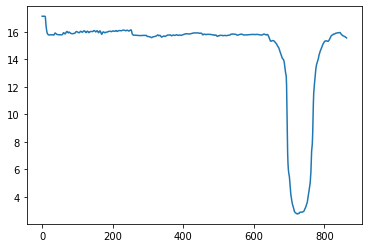

In [ ]:
plt.plot(cnv.data['tv290C'])

## Figures

In [ ]:
def profile_CTD(cast_path):
  df = pd.read_excel(cast_path, sheet_name=1)
  station_str = df.columns[0]
  df.drop(df.columns[-1], axis=1, inplace=True)
  df.replace(np.nan, '', inplace=True)
  df.columns = df.iloc[0].values + ' ' + df.iloc[1].values
  df.drop([0, 1], inplace=True)
  df = df.astype(np.float64)

  ### Hour of CTD cast
  df2 = pd.read_excel(cast_path, sheet_name=0)
  ind2 = df2[df2.iloc[:,1] == 'cast'].index[0]
  hour = df2.iloc[ind2, 6]

  fig, ax = plt.subplots(4,3, figsize=(10,13), sharey=True)
  axs = ax.flatten()
  axs[0].invert_yaxis()
  axs[0].yaxis.set_major_locator(plt.MultipleLocator(1))
  for i in range(12):
    axs[i].plot(df.iloc[:,i], df.iloc[:,2])
    axs[i].set_title(df.columns.values[i])
    axs[i].xaxis.set_ticks_position('top')
    axs[i].xaxis.set_major_locator(plt.AutoLocator())
  fig.supylabel('Depth [m]')
  fig.suptitle(station_str + ' ' + hour.strftime("%H:%M:%S"))
  fig.tight_layout()
  fig.subplots_adjust(top=0.92)
  plt.savefig('/content/drive/MyDrive/fjord_Saguenay/figs_ctd/'+mission_n+'/'+cast_path[-12:-4], dpi=300, facecolor='w')

mission_n = 'mission_4'
casts_dir = '/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_Excel/'+mission_n+'/cast*.xlsx'
fnames = glob.glob(casts_dir)

for fname in fnames:
  print(fname)
  profile_CTD(fname)

Output hidden; open in https://colab.research.google.com to view.

# Vertical sections

In [ ]:
### Run Bathymetry section in order to load dep_grid

## Bathy preps

[   6.23  -14.53    5.41   -8.66  -20.11  -66.12  -65.69  -68.08  -80.37
  -82.11  -86.27  -87.89  -91.56  -91.56  -93.01  -94.31  -95.71  -97.3
  -98.43 -100.14 -101.22 -102.3  -103.2  -104.   -105.05 -105.98 -107.94
 -108.51 -109.6  -111.13 -112.41 -111.75 -112.36 -113.73 -114.73 -115.75
 -115.28 -116.03 -115.62 -110.87  -89.22  -73.28  -69.56  -46.47  -45.23
  -21.4    -9.5    -8.53]
[  -9.5    -8.53  -45.44  -29.23  -38.25  -45.85  -29.84  -42.1   -44.58
  -40.22  -81.7   -93.59  -93.78  -96.77 -124.63 -132.28 -136.19 -140.82
 -140.82 -141.66 -141.87 -141.86 -141.86 -142.49 -142.55 -141.5  -141.5
 -142.54 -141.83 -141.25 -141.35 -123.28    5.77    5.73     nan]


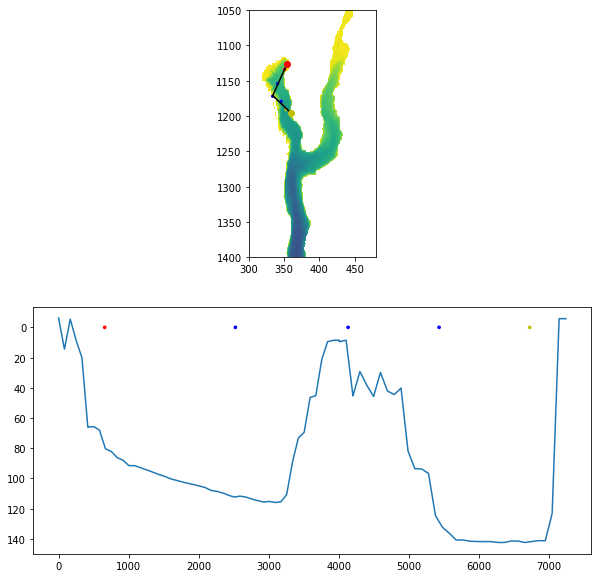

In [ ]:
#### Generate vertical sections bathymetry profiles

def find_lonlat(lo, la):
  return np.where(Lon==round(lo, 3))[0][0], np.where(Lat==round(la, 3))[0][0]

### Coords of 3 stations for vertical section
# lo1, la1 = -71.05363899, 48.43279779   # st 1
# lo1, la1 = -71.00294167, 48.4506083   # st 2
# lo2, la2 = -70.96551111, 48.4455694   # st 3
# lo1, la1 = -70.92509444, 48.4351444   # st 4
# lo2, la2 = -70.88678333, 48.4280611   # st 5
# lo3, la3 = -70.83505953, 48.41662455   # st 6
# lo2, la2 = -70.83946383, 48.41338998   # st 7
# lo1, la1 = -70.84297754, 48.4101482   # st 8
# lo1, la1 = -70.75592249, 48.41154575   # st 9
# lo1, la1 = -70.74600586, 48.38893676   # st 10
# lo2, la2 = -70.73505844, 48.38858995   # st 11
# lo3, la3 = -70.72341914, 48.38739753   # st 12
# lo1, la1 = -70.77277637, 48.36288178   # st 13
lo5, la5 = -70.80879998, 48.35332171   # st 14
lo4, la4 = -70.82113777, 48.34597312   # st 15
lo3, la3 = -70.82845236, 48.33415047   # st 16
lo2, la2 = -70.84598319, 48.34088204   # st 17
lo1, la1 = -70.86557598, 48.35080985   # st 18
# lo1, la1 = -70.73750427, 48.35700723   # st 19
# lo2, la2 = -70.72554028, 48.36423599   # st 20
# lo3, la3 = -70.71051611, 48.3734102   # st 21
# lo1, la1 = -70.62322855, 48.35762533   # st 22
# lo2, la2 = -70.61956649, 48.36611331   # st 23
# lo3, la3 = -70.61598996, 48.37442746   # st 24

ilo1, ila1 = find_lonlat(lo1, la1)
ilo2, ila2 = find_lonlat(lo2, la2) 
ilo3, ila3 = find_lonlat(lo3, la3)  
ilo4, ila4 = find_lonlat(lo4, la4)  
ilo5, ila5 = find_lonlat(lo5, la5)  

x, y = np.array([ila1, ila2, ila3]), np.array([ilo1, ilo2, ilo3])
xx, yy = np.array([ila3, ila4, ila5]), np.array([ilo3, ilo4, ilo5])
A = np.vstack([x, np.ones(len(x))]).T
AA = np.vstack([xx, np.ones(len(xx))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
mm, cc = np.linalg.lstsq(AA, yy, rcond=None)[0]
x0, x1 = ila1 + 3, ila3
y0, y1 = m*x0 + c, m*x1 + c
xx0, xx1 = ila3, ila5 + 7
yy0, yy1 = mm*xx0 + cc, mm*xx1 + cc
# print(x0, y0, x1, y1)

fig, ax = plt.subplots(2,1, figsize=(10,10))
cf = ax[0].imshow(dep_grid)
ax[0].set_xlim([300, 480])    # fig limits to visualize better
ax[0].set_ylim([1400, 1050])
ax[0].scatter([ila1, ila2, ila3, ila4, ila5], [ilo1, ilo2, ilo3, ilo4, ilo5], s=5, c=['r', 'b', 'b', 'b', 'y'])
ax[0].plot([x0, x1], [y0, y1], 'k-')
ax[0].plot([xx0, xx1], [yy0, yy1], 'k-')
ax[0].plot(x0, y0, 'ro')
ax[0].plot(xx1, yy1, 'yo')

# num_points = 1000
# x = np.linspace(x0, x1, num_points)
# y = np.linspace(y0, y1, num_points)
length = int(np.hypot(x1-x0, y1-y0))
length_2 = int(np.hypot(xx1-xx0, yy1-yy0))
x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)
xx, yy = np.linspace(xx0, xx1, length_2), np.linspace(yy0, yy1, length_2)
zi_hypot = dep_grid[y.astype(int), x.astype(int)]
zi_hypot_2 = dep_grid[yy.astype(int), xx.astype(int)]

for i, z in enumerate(zi_hypot):
  if np.isnan(z):           ### extend last depth value to 0 (margin), if not present
    continue                ### For transversal sections only
  else:
    if z < 0:
      zi_hypot[i-1] = 0
    break
for i, z in reversed(list(enumerate(zi_hypot_2[:-1]))):
  if np.isnan(z):           ### other margin
    continue
  else:
    if z < 0:
      zi_hypot_2[i+1] = 0
    break

print(zi_hypot)
print(zi_hypot_2)

dist_0f = geopy.distance.geodesic([Lat[x0], Lon[int(y0)]], [Lat[x1], Lon[int(y1)]]).m  ### geodesic distance of section in m
dist_0f_2 = geopy.distance.geodesic([Lat[xx0], Lon[int(yy0)]], [Lat[xx1], Lon[int(yy1)]]).m
lendist = dist_0f / length  # conversion factor for section = meter / data
lendist_2 = dist_0f_2 / length_2
zi_interp = np.arange(0, dist_0f, lendist)
zi_interp_2 = np.arange(0, dist_0f_2, lendist_2)
zi = np.interp(range(int(dist_0f)), zi_interp, zi_hypot)  # interpolate bathymetry to each m through section
zi_2 = np.interp(range(int(dist_0f_2)), zi_interp_2, zi_hypot_2) 

pos1 = np.hypot(ila1-x0, ilo1-y0) * lendist  # st. positions in bathymetry section [length]
pos2 = np.hypot(ila2-x0, ilo2-y0) * lendist
pos3 = np.hypot(ila3-x0, ilo3-y0) * lendist
pos4 = np.hypot(ila4-xx0, ilo4-yy0) * lendist_2 + dist_0f
pos5 = np.hypot(ila5-xx0, ilo5-yy0) * lendist_2 + dist_0f
ax[1].scatter([pos1, pos2, pos3, pos4, pos5], [0,0,0,0,0], s=7, marker='o', c=['r', 'b', 'b', 'b', 'y'])

# zi[:9700] = np.nan  # mask low depths in L1 and L2 (RivUpFjo)
zi = np.concatenate((zi, zi_2))
ax[1].plot(-zi)
ax[1].invert_yaxis()

pos_st = [pos1, pos2, pos3, pos4, pos5]

np.savetxt('/content/drive/MyDrive/fjord_Saguenay/zi_BathyVertProfiles/T4+5_LaBaie_zi.csv', zi, delimiter=',')
np.savetxt('/content/drive/MyDrive/fjord_Saguenay/zi_BathyVertProfiles/T4+5_LaBaie_st18-14.csv', pos_st, delimiter=',')

## Vertical sec figures

In [10]:
### Load tides data
df1 = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/predictions_03480_Chicoutimi_2019-06-03.csv')
df2 = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/predictions_03480_Chicoutimi_2019-06-10.csv')
df3 = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/predictions_03480_Chicoutimi_2019-06-17.csv')
df4 = pd.read_csv('/content/drive/MyDrive/fjord_Saguenay/predictions_03480_Chicoutimi_2019-06-24.csv')
tides = pd.concat([df1, df2, df3, df4], ignore_index=True)
del(df1, df2, df3, df4)
tides['Date'] = tides['Date'].astype('datetime64[ns]')

/usr/local/lib/python3.9/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Vertical sections
- mission 2: casts 36, 37, 38 
  - longitudinal St 4, 5, 6 - St. Fulgence à Cap Jaseux
  - 12 jun 8:44-9:22-9:54 - low tide 6:43
- mission 2: casts 39, 40, 41 
  - transversal St 22, 23, 24 - St. Rose
  - 12 jun 12:02-12:30-13:16 - high tide 11:47
- mission 2: casts 43, 44, 45
  - transversal St 19, 20, 21 - Cap à l'Est 
  - 12 jun 14:45-15:12-15:42 - low tide 19:14
- mission 2: casts 49, 48, 47
  - transversal St 10, 11, 12 - entrée bras nord
  - 13 jun 10:04-10:36-11:04 - L 7:54  H 12:53
- mission 2: casts 52, 51, 50
  - transversal St 16, 15, 14 - mi La Baie
  - 13 jun 11:56-12:22-12:50 - H 12:53
- mission 2: casts 54, 53, 52
  - transversal St 18, 17, 16 - fond La Baie
  - 13 jun 12:50-13:19-13:46 - H 12:53 L 20:09
- mission 3: casts 56, 57, 58
  - transversal St 8, 7, 6 - Cap Jaseux
  - 17 jun 9:32-9:58-10:30 - H 3:38 L 11:35
- mission 3: casts 62-58
  - longitudinal St 2,3,4,5,6 - Canton-Tremblay à Cap Jaseux
  - 17 jun 10:30-11:03-11:42-12:21-12:57 - L 11:35 H 16:16
- mission 3: casts 68-66
  - transversal St 16,15,14 - mi La Baie
  - 18 jun 10:57-11:46-12:15 - L 12:18 H 16:58
- mission 3: casts 71-73
  - transversal St 10,11,12 - entrée Bras Nord
  - 19 jun 9:14-9:48-10:18 - H 5:01 L 12:56
- mission 3: casts 76-74
  - transversal St 19,20,21 - Cap à l'Est
  - 19 jun 12:08-11:38-10:53
- mission 3: casts 77-79
  - T6 St Rose - St 22,23,24
  - 19 jun 12:59-13:29-13:58
- mission 4: casts 02-04
  - T1 Cap Jaseux - St 8,7,6
  - 25 jun 10:07 10:37 11:11
- mission 4: casts 08-04
  - L2 RivUpFjord - St 2,3,4,5,6
  - 25 jun 13:58 13:29 12:50 12:07 11:11
- mission 4: casts 13-11
  - T4 Mi La Baie - St 16,15,14
  - 26 jun 11:49 11:14 10:45
- mission 4: casts 16-18
  - T2 Bras Nord - St 10,11,12
  - 27 jun 10:43 11:21 11:47
- mission 4: casts 21-19
  - T3 Cap à l'Est - St 19,20,21
  - 27 jun 13:34 13:08 12:40
- mission 4: casts 22-24
  - T6 St Rose - St 22,23,24
  - 27 jun 14:15 14:47 15:14

T ->  2.5821 15.8112
S ->  3.7284 24.7363


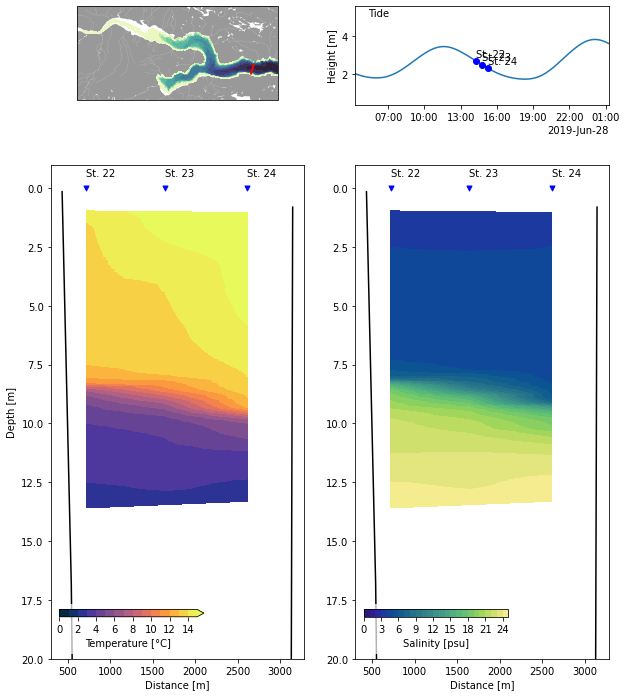

In [ ]:
### Coords of 3 stations for vertical section
# lo1, la1 = -71.05363899, 48.43279779   # st 1
# lo1, la1 = -71.00294167, 48.4506083   # st 2
# lo2, la2 = -70.96551111, 48.4455694   # st 3
# lo3, la3 = -70.92509444, 48.4351444   # st 4
# lo4, la4 = -70.88678333, 48.4280611   # st 5
# lo5, la5 = -70.83505953, 48.41662455   # st 6
# lo2, la2 = -70.83946383, 48.41338998   # st 7
# lo1, la1 = -70.84297754, 48.4101482   # st 8
# lo1, la1 = -70.75592249, 48.41154575   # st 9
# lo1, la1 = -70.74600586, 48.38893676   # st 10
# lo2, la2 = -70.73505844, 48.38858995   # st 11
# lo3, la3 = -70.72341914, 48.38739753   # st 12
# lo1, la1 = -70.77277637, 48.36288178   # st 13
# lo3, la3 = -70.80879998, 48.35332171   # st 14
# lo2, la2 = -70.82113777, 48.34597312   # st 15
# lo1, la1 = -70.82845236, 48.33415047   # st 16
# lo2, la2 = -70.84598319, 48.34088204   # st 17
# lo1, la1 = -70.86557598, 48.35080985   # st 18
# lo1, la1 = -70.73750427, 48.35700723   # st 19
# lo2, la2 = -70.72554028, 48.36423599   # st 20
# lo3, la3 = -70.71051611, 48.3734102   # st 21
lo1, la1 = -70.62322855, 48.35762533   # st 22
lo2, la2 = -70.61956649, 48.36611331   # st 23
lo3, la3 = -70.61598996, 48.37442746   # st 24

### Mission, casts, hours, station names, bathy profile
mission_n = 'mission_4'
c1, c2, c3 = '22', '23', '24'   # 14:15 14:47 15:14
# c4, c5 = '05', '04'
hours = [np.datetime64('2019-06-27 14:15:00'), np.datetime64('2019-06-27 14:47:00'), np.datetime64('2019-06-27 15:14:00')]
        #  np.datetime64('2019-06-25 12:07:00'), np.datetime64('2019-06-25 11:11:00')]
sts = ['St. 22', 'St. 23', 'St. 24']
zi = np.genfromtxt('/content/drive/MyDrive/fjord_Saguenay/zi_BathyVertProfiles/T6_StRose_zi.csv', delimiter=',')
pos_st = np.genfromtxt('/content/drive/MyDrive/fjord_Saguenay/zi_BathyVertProfiles/T6_StRose_st22-24.csv', delimiter=',')

def get_profile(cast_path):
  df = pd.read_excel(cast_path, sheet_name=1)
  station_str = df.columns[0]
  df.drop(df.columns[-1], axis=1, inplace=True)
  df.replace(np.nan, '', inplace=True)
  df.columns = df.iloc[0].values + ' ' + df.iloc[1].values
  df.drop([0, 1], inplace=True)
  df = df.astype(np.float64)
  depth = df.iloc[:,2]
  temp = df.iloc[:,10]
  sal = df.iloc[:,8]

  return depth, temp, sal

### Data gathering
d1, t1, s1 = get_profile('/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_Excel/'+mission_n+'/cast '+c1+'.xlsx')
d2, t2, s2 = get_profile('/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_Excel/'+mission_n+'/cast '+c2+'.xlsx')
d3, t3, s3 = get_profile('/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_Excel/'+mission_n+'/cast '+c3+'.xlsx')
# d4, t4, s4 = get_profile('/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_Excel/'+mission_n+'/cast '+c4+'.xlsx')
# d5, t5, s5 = get_profile('/content/drive/MyDrive/fjord_Saguenay/2019_OSMO_DeriveLarvaire/Donnees/_CTD_Sag_OSMO/fichier_Excel/'+mission_n+'/cast '+c5+'.xlsx')

xax = np.concatenate((np.repeat(pos_st[0], d1.shape[0]), np.repeat(pos_st[1], d2.shape[0]), np.repeat(pos_st[2], d3.shape[0]))) 
                      # np.repeat(pos_st[3], d4.shape[0]), np.repeat(pos_st[4], d5.shape[0])))
depths = np.concatenate((d1, d2, d3))#, d4, d5))
temps = np.concatenate((t1, t2, t3))#, t4, t5))
sals = np.concatenate((s1, s2, s3))#, s4, s5))
print('T -> ', temps.min(), temps.max())
print('S -> ', sals.min(), sals.max())

#### FIG ####
fig, axs = plt.subplots(2, 2, figsize=(10, 12), gridspec_kw={'height_ratios':[1,5]})
axs = axs.flatten()

## Map
proj = ccrs.Mercator()
axs[0].remove()
ax = fig.add_subplot(6, 2, 1, projection=proj)
ax.set_extent([-71.1, -70.55, 48.31, 48.48])

ax.add_geometries(canada_p['geometry'], crs=proj, facecolor='0.6')
ax.add_geometries(canada_h['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_c['geometry'], crs=proj, facecolor='w')
ax.add_geometries(canada_d['geometry'], crs=proj, edgecolor='w', facecolor='None', linewidth=0.1)
pcm = ax.contourf(Lon, Lat, dep_grid.T, np.arange(-260, 20, 20),
                  transform=ccrs.PlateCarree(), zorder=30, 
                  cmap=cmocean.cm.deep_r)
ax.plot([lo1,lo2,lo3], [la1,la2,la3], 'r-', lw=2, transform=ccrs.Geodetic(), zorder=40)

## Tides
ax = axs[1]
ax.plot(tides['Date'], tides['predictions (m)'])
td = np.timedelta64(10, 'h')
ax.set_xlim([hours[0] - td, hours[-1] + td])
ax.text(.05, .9, 'Tide', transform=ax.transAxes)
ax.set_ylabel('Height [m]')

for i in zip(hours, sts):
  tides_sort = tides.iloc[(tides['Date']-i[0]).abs().argsort()[:1]]
  ax.plot(i[0], tides_sort['predictions (m)'], 'bo')
  ax.annotate(i[1], (i[0], tides_sort['predictions (m)']+.2))

locator = mdates.HourLocator(interval = 3)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for ax in [axs[2], axs[3]]:
  # zi[zi>-13] = np.nan       # mask low depths
  # zi[3000:5000] = np.nan
  ax.invert_yaxis()
  ax.set_ylim([20, -1])
  ax.plot(-zi, 'k-')
  ax.scatter(pos_st, np.repeat(0, 3), s=25, marker='v', fc='b')
  for i in range(3):
    ax.text(pos_st[i], -.5, sts[i])
  ax.set_xlabel('Distance [m]')

axs[2].set_ylabel('Depth [m]')

tcf_t = axs[2].tricontourf(xax, depths, temps, levels=np.arange(0,16), cmap=cmocean.cm.thermal, extend='max')
cbbox = inset_axes(axs[2], '60%', '10%', loc=3)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(axis='both', left=False, top=False, 
   right=False, bottom=False, labelleft=False,
    labeltop=False, labelright=False, labelbottom=False)
cbbox.set_facecolor([1,1,1,.7])
cbax = inset_axes(cbbox, '95%', '15%', loc = 9)
cb = plt.colorbar(tcf_t, cax=cbax, orientation='horizontal')
cb.set_label('Temperature [°C]')

tcf_s = axs[3].tricontourf(xax, depths, sals, np.arange(0,26), cmap=cmocean.cm.haline)
cbbox = inset_axes(axs[3], '60%', '10%', loc=3)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(axis='both', left=False, top=False, 
   right=False, bottom=False, labelleft=False,
    labeltop=False, labelright=False, labelbottom=False)
cbbox.set_facecolor([1,1,1,.7])
cbax = inset_axes(cbbox, '95%', '15%', loc = 9)
cb = plt.colorbar(tcf_s, cax=cbax, orientation='horizontal')
cb.set_label('Salinity [psu]')

# plt.tight_layout()
plt.savefig('/content/drive/MyDrive/fjord_Saguenay/figs_vertical_sections/T6_27jun.png', dpi=300, facecolor='w')